In [61]:
import numpy as np
import matplotlib.pyplot as plt

## Data import

In [62]:
# Configuraciones para diferentes posiciones de las anclas (referencias):
# "pos": indica coordenadas cartesianas (m)
# "angulo": indica el ángulo del ancla respecto de la vertical (rad)

config_1 = {
"P1":{"pos": (56.69873, 75.0),"angulo": -1.0471975493043784},
"P2":{"pos": (94.770655, 109.771682),"angulo": -0.08726646965814552},
"P3":{"pos": (135.355339, 85.355339),"angulo": 0.7853981633974481}
}

config_2 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (34.467836, 95.886115),"angulo": -0.9599310909314129},
"P3":{"pos": (39.818498, 129.863551),"angulo": -0.6457718207490258}
}

config_3 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (40.548414, 103.530449),"angulo": -0.8377580360740813},
"P3":{"pos": (35.721239, 126.604444),"angulo": -0.6981317030426971}
}

config_4 = {
"P1":{"pos": (64.644661, 85.355339),"angulo": -0.7853981633974483},
"P2":{"pos": (43.332813, 106.469726),"angulo": -0.7871434894299918},
"P3":{"pos": (29.412843, 120.833984),"angulo": -0.7836528320585269}
}

# Posición esperada para el objetivo
p = (100, 50)


# 1. Matemathical Model

In [63]:
def estimate_p(angles, positions):
    A = np.column_stack([np.cos(angles), -np.sin(angles)])    # Design matrix
    b = np.sum(A * positions, axis = 1) # Solutions for linear system
    At = A.T
    x = np.linalg.inv(At @ A) @ At @ b
    return  x, np.linalg.cond(A)    # Least Squares solution    

# 2. Simulation

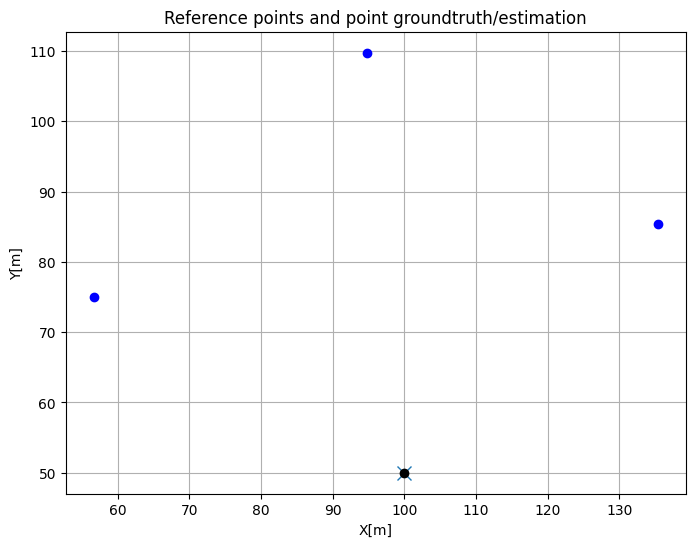

In [64]:
# Import config_1

theta_1 = np.array([config_1[p]['angulo'] for p in config_1.keys()])
pos_1 = np.array([config_1[p]['pos'] for p in config_1.keys()])

x, cond = estimate_p(theta_1, pos_1)

plt.figure(figsize=(8,6))
plt.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
plt.plot(x[0], x[1], 'x', markersize=10.0, label='̂p')
plt.plot(p[0], p[1], 'o', color='black', label='p')
plt.title('Reference points and point groundtruth/estimation')
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
plt.grid(True)
plt.show()

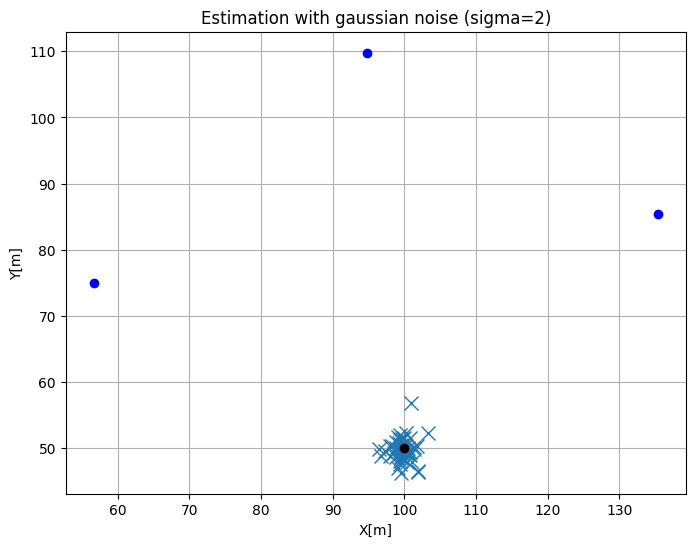

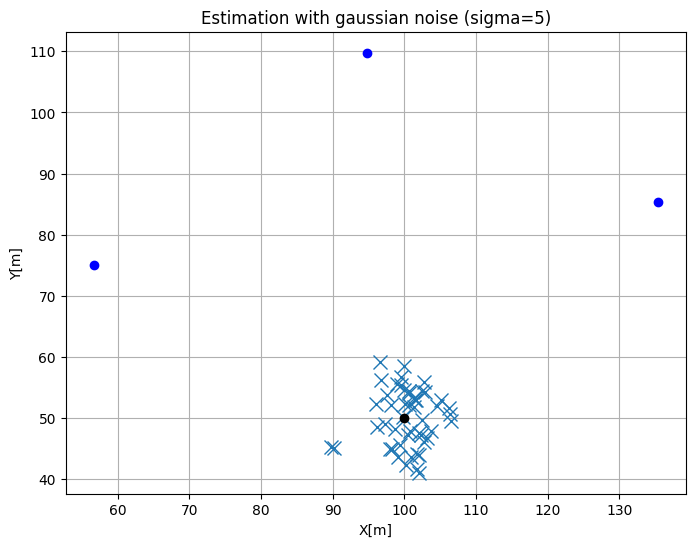

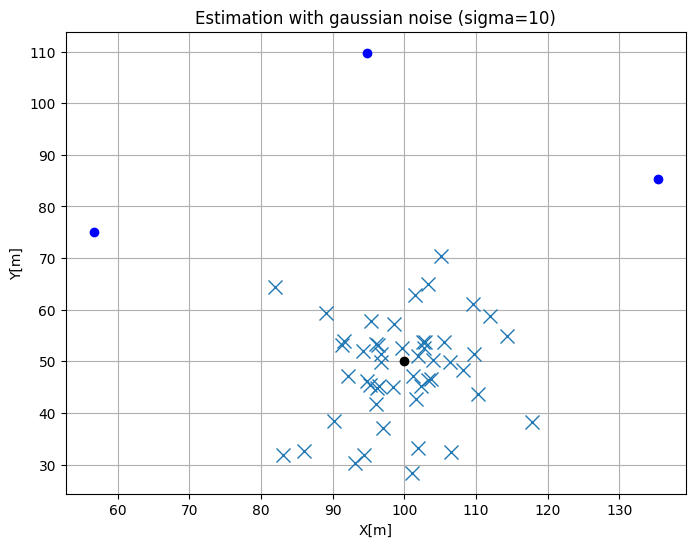

In [65]:
# Introducing gaussian noise to reference coordinates

rng = np.random.default_rng(42) # Random generator for reprodoctubility
sigmas = (2, 5, 10)
estimations = np.zeros((3, 50, 2))
for k in range(len(sigmas)):
    noisy_sampling = np.tile(pos_1, (50, 1, 1))
    noise = rng.normal(0, sigmas[k], size=(50, 3, 2))
    noisy_sampling += noise
    for i in range(noisy_sampling.shape[0]):
        x, cond = estimate_p(theta_1, noisy_sampling[i])
        estimations[k, i] = x

for i in range(estimations.shape[0]):
    plt.figure(figsize=(8,6))
    plt.plot(pos_1[:,0], pos_1[:,1], 'o', color='blue', label='p_ref')
    plt.plot(estimations[i,:,0], estimations[i,:,1], 'x', markersize=10.0, label='̂p')
    plt.plot(p[0], p[1], 'o', color='black', label='p')
    plt.title(f'Estimation with gaussian noise (sigma={sigmas[i]})')
    plt.xlabel('X[m]')
    plt.ylabel('Y[m]')
    plt.grid(True)
    plt.show()

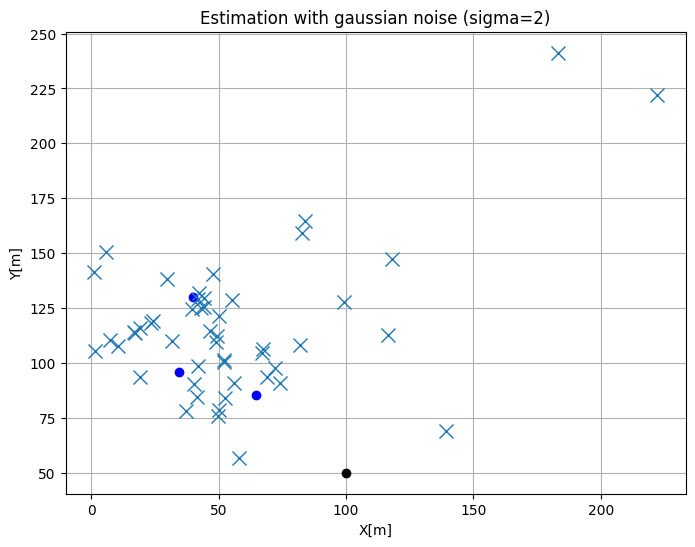

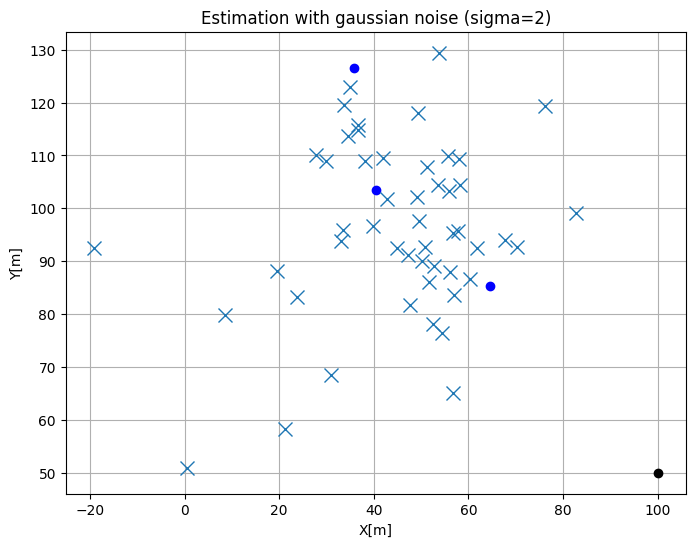

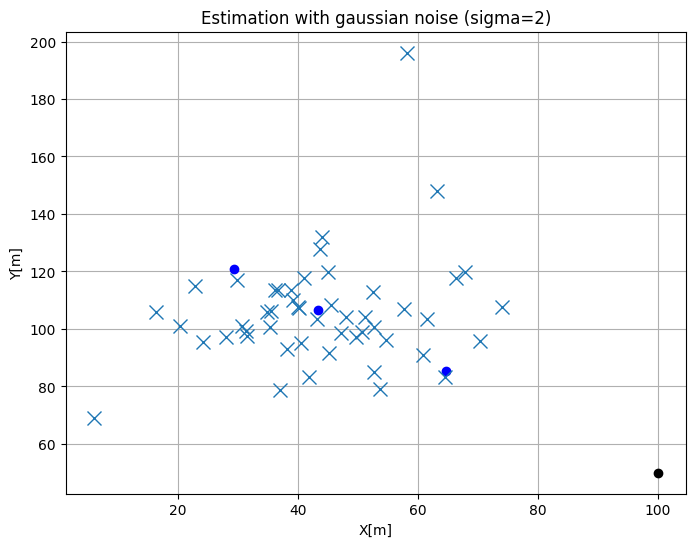

In [66]:
# Introducing gaussian noise to observed angles

thetas_234 = np.array([[config_2[p]['angulo'] for p in config_2.keys()],
                       [config_3[p]['angulo'] for p in config_3.keys()],
                       [config_4[p]['angulo'] for p in config_4.keys()]])
pos_234 = np.array([[config_2[p]['pos'] for p in config_2.keys()],
                    [config_3[p]['pos'] for p in config_3.keys()],
                    [config_4[p]['pos'] for p in config_4.keys()]
                   ])

rng = np.random.default_rng(42) # Random generator for reprodoctubility
sigma = 2
estimations = np.zeros((50, 3, 2))
noise_angles = np.tile(thetas_234, (50, 1, 1))
noise = rng.normal(0, sigma, size=(50, 3, 3))
noise_angles += noise
conditions = np.zeros((50, 3, 1))
for i in range(estimations.shape[0]):
    for j in range(estimations.shape[1]):
        x, cond = estimate_p(noise_angles[i,j,:], pos_234[j,:])
        estimations[i, j] = x

for i in range(estimations.shape[1]):
    plt.figure(figsize=(8,6))
    plt.plot(pos_234[i,:,0], pos_234[i,:,1], 'o', color='blue', label='p_ref')
    plt.plot(estimations[:,i,0], estimations[:,i,1], 'x', markersize=10.0, label='̂p')
    plt.plot(p[0], p[1], 'o', color='black', label='p')
    plt.title(f'Estimation with gaussian noise (sigma={sigma})')
    plt.xlabel('X[m]')
    plt.ylabel('Y[m]')
    plt.grid(True)
    plt.show()